In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_3d_mesh(nx, ny, nz, lx=1.0, ly=1.0, lz=1.0):
    """
    Generate a structured 3D hexahedral mesh grid.
    :param nx, ny, nz: number of elements in x, y, z direction
    :param lx, ly, lz: physical dimensions of the mesh
    :return: nodes (N x 3), elements (M x 8)
    """
    # Node coordinates
    x = np.linspace(0, lx, nx + 1)
    y = np.linspace(0, ly, ny + 1)
    z = np.linspace(0, lz, nz + 1)
    xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
    nodes = np.vstack((xv.flatten(), yv.flatten(), zv.flatten())).T

    # Element connectivity
    def node_index(i, j, k):
        return i * (ny + 1) * (nz + 1) + j * (nz + 1) + k

    elements = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                n0 = node_index(i, j, k)
                n1 = node_index(i + 1, j, k)
                n2 = node_index(i + 1, j + 1, k)
                n3 = node_index(i, j + 1, k)
                n4 = node_index(i, j, k + 1)
                n5 = node_index(i + 1, j, k + 1)
                n6 = node_index(i + 1, j + 1, k + 1)
                n7 = node_index(i, j + 1, k + 1)
                elements.append([n0, n1, n2, n3, n4, n5, n6, n7])
    return np.array(nodes), np.array(elements)

def plot_3d_mesh(nodes, elements):
    """
    Plot wireframe of 3D hexahedral mesh.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for elem in elements:
        verts = nodes[elem]
        # Draw bottom and top faces
        for face in [[0,1,2,3], [4,5,6,7]]:
            x, y, z = verts[face, 0], verts[face, 1], verts[face, 2]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            z = np.append(z, z[0])
            ax.plot(x, y, z, color='b')
        # Draw vertical lines
        for i in range(4):
            ax.plot([verts[i,0], verts[i+4,0]],
                    [verts[i,1], verts[i+4,1]],
                    [verts[i,2], verts[i+4,2]],
                    color='gray')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Structured Hexahedral Mesh')
    plt.tight_layout()
    plt.show()

# Example usage
nodes, elements = generate_3d_mesh(nx=3, ny=3, nz=2, lx=1.0, ly=1.0, lz=0.5)
plot_3d_mesh(nodes, elements)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# 정점 (8개 꼭짓점)
vertices = np.array([
    [0, 0, 0],  # 0
    [1, 0, 0],  # 1
    [1, 1, 0],  # 2
    [0, 1, 0],  # 3
    [0, 0, 1],  # 4
    [1, 0, 1],  # 5
    [1, 1, 1],  # 6
    [0, 1, 1],  # 7
])

# 면 (6면: 각 면은 꼭짓점 인덱스로 구성)
faces = [
    [vertices[i] for i in [0, 1, 2, 3]],  # bottom
    [vertices[i] for i in [4, 5, 6, 7]],  # top
    [vertices[i] for i in [0, 1, 5, 4]],  # front
    [vertices[i] for i in [2, 3, 7, 6]],  # back
    [vertices[i] for i in [1, 2, 6, 5]],  # right
    [vertices[i] for i in [0, 3, 7, 4]],  # left
]

# 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(Poly3DCollection(faces, facecolors='lightblue', linewidths=1, edgecolors='black', alpha=0.75))

# 축 범위 자동 설정
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_box_aspect([1,1,1])
plt.title("Simple Rectangular Box")
plt.show()


In [ ]:
print(len(faces),faces)

In [ ]:
from stl import mesh
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

your_mesh = mesh.Mesh.from_file('Cube_3d_printing_sample.stl')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(Poly3DCollection(your_mesh.vectors, alpha=0.5))
scale = your_mesh.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
plt.show()

In [ ]:
!pip install numpy-stl --break-system-packages

In [ ]:
print(your_mesh)

In [ ]:
import stl_reader

In [ ]:
!pip install stl-reader --break-system-packages

In [ ]:
import stl_reader
vertices, indices = stl_reader.read("Cube_3d_printing_sample.stl")

In [ ]:
print(vertices,indices)

In [9]:
def beam_element_stiffness(EI, L):
    """2D beam element local stiffness matrix (Euler-Bernoulli)"""
    return EI / (L**3) * np.array([
        [12,     6*L,   -12,    6*L],
        [6*L,   4*L**2, -6*L,   2*L**2],
        [-12,   -6*L,   12,    -6*L],
        [6*L,   2*L**2, -6*L,   4*L**2]
    ])

def assemble_global_stiffness(num_elements, EI_list, L_list):
    """전체 강성 행렬 K 구성"""
    dof = 2 * (num_elements + 1)  # 각 노드 당 2자유도 (변위, 회전)
    K = np.zeros((dof, dof))

    for i in range(num_elements):
        ke = beam_element_stiffness(EI_list[i], L_list[i])
        dof_indices = [2*i, 2*i+1, 2*i+2, 2*i+3]
        for ii in range(4):
            for jj in range(4):
                K[dof_indices[ii], dof_indices[jj]] += ke[ii, jj]
    return K

def apply_boundary_conditions(K, F, fixed_dofs):
    """고정 자유도에 대한 Dirichlet 경계조건 적용"""
    for dof in fixed_dofs:
        K[dof, :] = 0
        K[:, dof] = 0
        K[dof, dof] = 1
        F[dof] = 0
    return K, F

def solve_displacement(K, F):
    """선형 시스템 해석"""
    return np.linalg.solve(K, F)

def postprocess_results(U, num_nodes):
    """노드별 변위 및 회전 결과 출력"""
    for i in range(num_nodes):
        print(f"Node {i}: displacement = {U[2*i]:.6f} m, rotation = {U[2*i+1]:.6f} rad")


ValueError: operands could not be broadcast together with shapes (8,) (12,) 

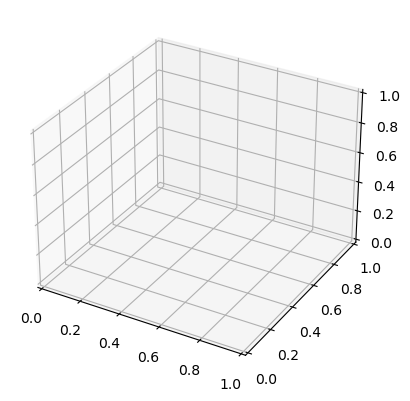

In [10]:
from stl import mesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 다중 요소 및 하중 적용 예제
num_elements = 5
L_list = [1.0] * num_elements
EI_list = [210e9 * 8.33e-6] * num_elements
dof = 2 * (num_elements + 1)

# 3. 간단한 강성 행렬 구성 (Z축 방향만 고려, 삼각형마다 3 DOF)
K = np.zeros((dof, dof))
F = np.zeros(dof)
F[4] = -500.0    # Node 2에 -500N
F[6] = -800.0    # Node 3에 -800N
F[2*num_elements] = -1000.0  # 마지막 노드에 -1000N


# 1. STL 파일 불러오기
your_mesh = mesh.Mesh.from_file('Cube_3d_printing_sample.stl')
triangles = your_mesh.vectors
num_triangles = len(triangles)

# 2. 노드 좌표 및 인덱스 정리
all_nodes = triangles.reshape(-1, 3)
nodes, inverse_indices = np.unique(all_nodes, axis=0, return_inverse=True)
num_nodes = len(nodes)

# 각 삼각형은 정점 3개
elements = inverse_indices.reshape(-1, 3)

K = assemble_global_stiffness(num_elements, EI_list, L_list)

# 5. 경계 조건 (맨 아래 노드 고정)
fixed_nodes = np.where(nodes[:, 2] < np.min(nodes[:, 2]) + 1e-5)[0]

for fn in fixed_nodes:
    K[fn, :] = 0
    K[:, fn] = 0
    K[fn, fn] = 1
    F[fn] = 0

# 6. 선형 시스템 풀이
U = np.linalg.solve(K, F)

# 7. 결과 시각화 (Z축 변형을 색상으로 표현)
displacement_z = U * 10  # 과장 계수

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
face_colors = displacement_z[elements].mean(axis=1)

# Poly3DCollection 생성
collection = Poly3DCollection(nodes[elements], array=face_colors, cmap='viridis', edgecolor='k')
collection.set_clim([np.min(displacement_z), np.max(displacement_z)])
ax.add_collection3d(collection)

ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2] + displacement_z, s=1, c='r')
ax.auto_scale_xyz(nodes[:, 0], nodes[:, 1], nodes[:, 2])
ax.set_title("STL-based FEM Deformation (Z only)")

plt.colorbar(collection, ax=ax, label='Displacement (Z-dir)')
plt.tight_layout()
plt.show()


In [12]:
# 다중 요소 및 하중 적용 예제
num_elements = 5
L_list = [1.0] * num_elements
EI_list = [210e9 * 8.33e-6] * num_elements
dof = 2 * (num_elements + 1)

F = np.zeros(dof)
F[4] = -500.0    # Node 2에 -500N
F[6] = -800.0    # Node 3에 -800N
F[2*num_elements] = -1000.0  # 마지막 노드에 -1000N

fixed_dofs = [0, 1]  # 고정단

K = assemble_global_stiffness(num_elements, EI_list, L_list)
print(K)
K, F = apply_boundary_conditions(K, F, fixed_dofs)
print(K)
U = solve_displacement(K, F)

plot_3d_deformed_shape(U, L_list)

[[ 20991600.  10495800. -20991600.  10495800.         0.         0.
          0.         0.         0.         0.         0.         0.]
 [ 10495800.   6997200. -10495800.   3498600.         0.         0.
          0.         0.         0.         0.         0.         0.]
 [-20991600. -10495800.  41983200.         0. -20991600.  10495800.
          0.         0.         0.         0.         0.         0.]
 [ 10495800.   3498600.         0.  13994400. -10495800.   3498600.
          0.         0.         0.         0.         0.         0.]
 [        0.         0. -20991600. -10495800.  41983200.         0.
  -20991600.  10495800.         0.         0.         0.         0.]
 [        0.         0.  10495800.   3498600.         0.  13994400.
  -10495800.   3498600.         0.         0.         0.         0.]
 [        0.         0.         0.         0. -20991600. -10495800.
   41983200.         0. -20991600.  10495800.         0.         0.]
 [        0.         0.         0.       

NameError: name 'plot_3d_deformed_shape' is not defined

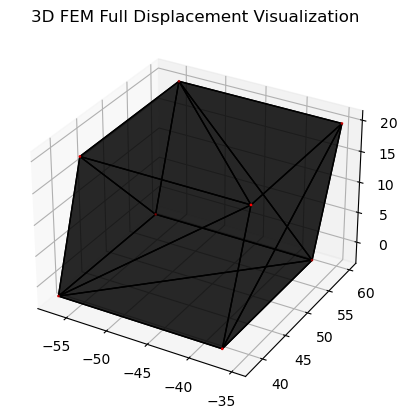

In [19]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from stl import mesh

def load_stl_and_extract_nodes_elements(stl_path):
    stl_mesh = mesh.Mesh.from_file(stl_path)
    all_nodes = stl_mesh.vectors.reshape(-1, 3)
    nodes, inverse_indices = np.unique(all_nodes, axis=0, return_inverse=True)
    elements = inverse_indices.reshape(-1, 3)
    return nodes, elements

def assemble_stiffness_matrix(nodes, elements, young_modulus, poisson_ratio):
    num_nodes = len(nodes)
    dof = 3 * num_nodes
    K = lil_matrix((dof, dof))

    # Simplified stiffness matrix per triangle (not physically accurate, placeholder for demonstration)
    ke = np.eye(9) * young_modulus / (1 - poisson_ratio**2) * 1e-3

    for elem in elements:
        dof_indices = []
        for node in elem:
            dof_indices.extend([3 * node, 3 * node + 1, 3 * node + 2])
        for i in range(9):
            for j in range(9):
                K[dof_indices[i], dof_indices[j]] += ke[i, j]
    return K

def apply_boundary_conditions(K, F, fixed_nodes):
    for node in fixed_nodes:
        for i in range(3):
            idx = 3 * node + i
            K[idx, :] = 0
            K[:, idx] = 0
            K[idx, idx] = 1
            F[idx] = -0.002
    return K, F

def visualize_displacement(nodes, elements, U, scale=1.0):
    displaced_nodes = nodes + scale * U.reshape((-1, 3))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    collection = Poly3DCollection(displaced_nodes[elements], facecolors='black', edgecolors='k', alpha=0.6)
    ax.add_collection3d(collection)
    ax.scatter(displaced_nodes[:, 0], displaced_nodes[:, 1], displaced_nodes[:, 2], color='r', s=1)
    ax.auto_scale_xyz(displaced_nodes[:, 0], displaced_nodes[:, 1], displaced_nodes[:, 2])
    ax.set_title("3D FEM Full Displacement Visualization")
    plt.show()

# Parameters
stl_file = 'Cube_3d_printing_sample.stl'
E = 210e9
nu = 0.3

try:
    nodes, elements = load_stl_and_extract_nodes_elements(stl_file)
    K = assemble_stiffness_matrix(nodes, elements, E, nu)
    #print(K.toarray())
    F = np.zeros(3 * len(nodes))

    # Apply downward force in Z at topmost nodes
    top_nodes = np.where(nodes[:, 2] > np.max(nodes[:, 2]) - 1e-5)[0]
    for node in top_nodes:
        F[3 * node + 2] = -1e5

    # Fix bottom nodes (Dirichlet BC)
    bottom_nodes = np.where(nodes[:, 2] < np.min(nodes[:, 2]) + 1e-5)[0]
    K_bc, F_bc = apply_boundary_conditions(K, F, bottom_nodes)

    # Solve
    U = spsolve(K_bc, F_bc)
    visualize_displacement(nodes, elements, U, scale=1000)

except FileNotFoundError:
    print(f"STL file '{stl_file}' not found. Please provide a valid STL file path.")


In [ ]:
print(nodes, elements)
print(bottom_nodes)

In [11]:
from stl import mesh
import numpy as np

In [12]:
# Parameters
stl_file = 'Cube_3d_printing_sample.stl'

stl_mesh = mesh.Mesh.from_file(stl_file)
all_nodes = stl_mesh.vectors.reshape(-1, 3)

In [ ]:
num_nodes = len(nodes)
    dof = 3 * num_nodes
    K = lil_matrix((dof, dof))

    # Simplified stiffness matrix per triangle (not physically accurate, placeholder for demonstration)
    ke = np.eye(9) * young_modulus / (1 - poisson_ratio**2) * 1e-3

    for elem in elements:
        dof_indices = []
        for node in elem:
            dof_indices.extend([3 * node, 3 * node + 1, 3 * node + 2])
        for i in range(9):
            for j in range(9):
                K[dof_indices[i], dof_indices[j]] += ke[i, j]

In [6]:
print(3*2+1)

7
